In [1]:
# from google.colab import drive
# drive.mount('/content/drive')

# Redes Neurais: Autoencoders
* Redução de Dimensionalidade
* Problemas não supervisionados (clusterização)

Autor: Arthur Schneider Figueira

In [2]:
import tensorflow as tf
from tensorflow.keras.layers import Input, Dense
from tensorflow.keras.models import Model
from sklearn.datasets import load_breast_cancer
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score,mean_squared_error
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import math

2023-10-16 23:52:49.061255: I tensorflow/core/util/port.cc:111] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2023-10-16 23:52:49.153663: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2023-10-16 23:52:49.519695: E tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:9342] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2023-10-16 23:52:49.519713: E tensorflow/compiler/xla/stream_executor/cuda/cuda_fft.cc:609] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2023-10-16 23:52:49.521891: E tensorflow/compiler/xla/stream_executor/cuda/cuda_blas.cc:1518] Unable to register cuBLAS factory: Attempting to regi

In [3]:
pd.set_option('display.max_columns', 25)

In [4]:
# Define a semente
seed_value = 2023
tf.random.set_seed(seed_value)
np.random.seed(seed_value)

# Contexto & Entendimento da base

O [Medium](https://medium.com/) é uma plataforma para lermos textos de diversos assuntos diferentes. É uma boa fonte para nos atualizarmos ou buscarmos uma introdução a um tema.

Neste laboratório, acessaremos uma base composta por um conjunto de artigos do medium e buscaremos separar os tipos de textos, conforme seus temas.

In [5]:
df = pd.read_csv("medium_articles.csv")
df.tail()

,title,text,url,authors,timestamp,tags
192363,Why do you need a cleaning service?,What could be more important than having a tid...,https://medium.com/@ozneedcleaningau/why-do-yo...,[],2021-11-16 08:17:08.950000+00:00,"['Cleaning', 'Cleaning Services', 'Cleaning Co..."
192364,Daily cleaning and maintenance of bedding,Daily cleaning and maintenance of bedding\n\nW...,https://medium.com/@a198blwt/daily-cleaning-an...,[],2021-11-16 05:27:05.359000+00:00,"['Bedding', 'Cleaning', 'Maintain']"
192365,Beneficial Advice on Bond Cleaning!,The most important chore at the end is bond cl...,https://medium.com/@princegohil/beneficial-adv...,['Prince Shrawan'],2021-11-26 08:20:27.660000+00:00,"['Cleaning', 'End Of Lease Cleaning', 'Cleaners']"
192366,How I Learned Romanian in 37 Easy Steps,How I Learned Romanian in 37 Easy Steps\n\nHey...,https://medium.com/@lifeinromania/how-i-learne...,['Sam Ursu'],2017-11-27 08:09:19.025000+00:00,"['Romania', 'Language Learning', 'Storyofmylife']"
192367,Trying Pimsleur Cantonese in Hong Kong,"Over the past few years, I’ve heard a number o...",https://medium.com/toshuo/trying-pimsleur-cant...,[],2017-06-15 02:24:35.659000+00:00,"['Hong Kong', 'Cantonese', 'Language Learning'..."


In [6]:
temas = []

for i in range(0,len(df)):
  for tag in df['tags'][i].replace("'",'').replace('[','').replace(']','').split(", "): #Precisei corrigir o texto e usar o split
    temas.append(tag)
len(temas)

880602

In [7]:
temas[0:10]

['Mental Health',
 'Health',
 'Psychology',
 'Science',
 'Neuroscience',
 'Mental Health',
 'Coronavirus',
 'Science',
 'Psychology',
 'Neuroscience']

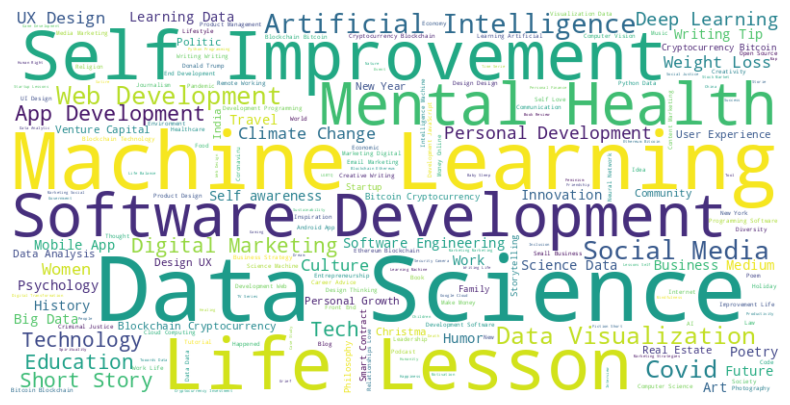

In [8]:
#Principais temas, ilustrado num mapa de palavras
from wordcloud import WordCloud

# Converta a lista de palavras em uma única string
texto = " ".join(temas)

# Crie um objeto WordCloud
wordcloud = WordCloud(width=800, height=400, background_color='white').generate(texto)

# Plote a nuvem de palavras usando Matplotlib
plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')  # Desativa os eixos
plt.show()

In [9]:
len(set(temas))

78639

In [10]:
from collections import Counter

contagem = Counter(temas)
print(contagem)

Counter({'Blockchain': 7534, 'Data Science': 7410, 'Technology': 6384, 'Programming': 6364, 'Poetry': 6336, 'Cryptocurrency': 6245, 'Machine Learning': 6055, 'Life': 5954, 'Bitcoin': 5800, 'Writing': 5115, 'Politics': 5074, 'Startup': 4974, 'Life Lessons': 4807, 'Self Improvement': 4267, 'Covid 19': 4176, 'Software Development': 3980, 'Love': 3978, 'Python': 3943, 'Business': 3722, 'Health': 3650, 'Mental Health': 3583, 'JavaScript': 3487, 'Relationships': 3377, 'Education': 3269, 'Artificial Intelligence': 3222, 'Culture': 3027, 'Design': 2932, 'Self': 2876, 'Marketing': 2791, 'Entrepreneurship': 2782, 'Ethereum': 2731, 'Music': 2524, 'Productivity': 2510, 'Web Development': 2498, 'History': 2418, 'Humor': 2386, 'Data Visualization': 2332, 'Leadership': 2317, 'Social Media': 2284, 'Psychology': 2200, 'Travel': 2138, 'Fiction': 2128, 'Creativity': 2069, 'Coronavirus': 2043, 'Parenting': 1983, 'Crypto': 1889, 'Science': 1879, 'Tech': 1850, 'UX': 1818, 'Short Story': 1815, 'Money': 1797,

In [11]:
# Converta o objeto Counter em um DataFrame do pandas
contador = pd.DataFrame.from_dict(contagem, orient='index', columns=['Contagem'])
contador = contador.sort_values(by='Contagem',ascending=False).reset_index()
contador.head(30)

,index,Contagem
0,Blockchain,7534
1,Data Science,7410
2,Technology,6384
3,Programming,6364
4,Poetry,6336
5,Cryptocurrency,6245
6,Machine Learning,6055
7,Life,5954
8,Bitcoin,5800
9,Writing,5115


In [12]:
top50_temas = list(contador['index'][0:50])

for topico in top50_temas: #Para cada um dos top 50 temas
  aux = [] #Criando uma lista vazia
  for i in range(0,len(df)): #Para cada linha da tabela
    if topico in df['tags'][i]: #Se o topico fizer parte da tag, vale 1
      aux.append(1)
    else:
      aux.append(0) #Caso contrario, vale 0
  df[topico] = aux #Criando uma coluna para cada topico

In [13]:
df.head()

,title,text,url,authors,timestamp,tags,Blockchain,Data Science,Technology,Programming,Poetry,Cryptocurrency,...,Social Media,Psychology,Travel,Fiction,Creativity,Coronavirus,Parenting,Crypto,Science,Tech,UX,Short Story
0,Mental Note Vol. 24,Photo by Josh Riemer on Unsplash\n\nMerry Chri...,https://medium.com/invisible-illness/mental-no...,['Ryan Fan'],2020-12-26 03:38:10.479000+00:00,"['Mental Health', 'Health', 'Psychology', 'Sci...",0,0,0,0,0,0,...,0,1,0,0,0,0,0,0,1,0,0,0
1,Your Brain On Coronavirus,Your Brain On Coronavirus\n\nA guide to the cu...,https://medium.com/age-of-awareness/how-the-pa...,['Simon Spichak'],2020-09-23 22:10:17.126000+00:00,"['Mental Health', 'Coronavirus', 'Science', 'P...",0,0,0,0,0,0,...,0,1,0,0,0,1,0,0,1,0,0,0
2,Mind Your Nose,Mind Your Nose\n\nHow smell training can chang...,https://medium.com/neodotlife/mind-your-nose-f...,[],2020-10-10 20:17:37.132000+00:00,"['Biotechnology', 'Neuroscience', 'Brain', 'We...",0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0,0,0
3,The 4 Purposes of Dreams,Passionate about the synergy between science a...,https://medium.com/science-for-real/the-4-purp...,['Eshan Samaranayake'],2020-12-21 16:05:19.524000+00:00,"['Health', 'Neuroscience', 'Mental Health', 'P...",0,0,0,0,0,0,...,0,1,0,0,0,0,0,0,1,0,0,0
4,Surviving a Rod Through the Head,"You’ve heard of him, haven’t you? Phineas Gage...",https://medium.com/live-your-life-on-purpose/s...,['Rishav Sinha'],2020-02-26 00:01:01.576000+00:00,"['Brain', 'Health', 'Development', 'Psychology...",0,0,0,0,0,0,...,0,1,0,0,0,0,0,0,1,0,0,0


In [14]:
import plotly.express as px

#Calculando a correlação e mantendo apenas baixas correlacoes
corr = df[top50_temas].corr(method='pearson', min_periods=1)
for col in top50_temas:
  corr = corr.loc[((corr[col] > -0.10) & (corr[col] < 0.10)) | (corr[col] == 1)]

corr = corr[list(corr.index)]

mask = np.triu(np.ones_like(corr, dtype=bool))
corr = corr.mask(mask)
fig = px.imshow(corr, #Fonte de dados é a tabela de correlação
                text_auto=True, #Inseri o nome dos dados
                color_continuous_scale=px.colors.diverging.RdBu, #As cores serão de azul (1) a vermelho (-1)
                zmin=-1,zmax=1 #defino que o minimo é -1 e o maximo é 1
                )


fig.update_layout(
    title_text='Correlações entre variáveis numéricas', #titulo
    title_x=0.5,  #Titulo centralizado
    width=700, #largura
    height=700, #altura
    xaxis_showgrid=False, #Para omitir as linhas de grade no eixo x
    yaxis_showgrid=False, #Para omitir as linhas de grade no eixo y
    template='plotly_white' #template
)

fig.show()

In [15]:
contador.loc[(contador['index'].isin(list(corr.index)))]

,index,Contagem
10,Politics,5074
23,Education,3269
25,Culture,3027
31,Music,2524
34,History,2418
35,Humor,2386
37,Leadership,2317
40,Travel,2138
44,Parenting,1983


# Exemplo prático

Vamos montar um projeto para separar os temas de Parenting, Travel e Leadership e Humor.

In [16]:
df.columns

Index(['title', 'text', 'url', 'authors', 'timestamp', 'tags', 'Blockchain',
       'Data Science', 'Technology', 'Programming', 'Poetry', 'Cryptocurrency',
       'Machine Learning', 'Life', 'Bitcoin', 'Writing', 'Politics', 'Startup',
       'Life Lessons', 'Self Improvement', 'Covid 19', 'Software Development',
       'Love', 'Python', 'Business', 'Health', 'Mental Health', 'JavaScript',
       'Relationships', 'Education', 'Artificial Intelligence', 'Culture',
       'Design', 'Self', 'Marketing', 'Entrepreneurship', 'Ethereum', 'Music',
       'Productivity', 'Web Development', 'History', 'Humor',
       'Data Visualization', 'Leadership', 'Social Media', 'Psychology',
       'Travel', 'Fiction', 'Creativity', 'Coronavirus', 'Parenting', 'Crypto',
       'Science', 'Tech', 'UX', 'Short Story'],
      dtype='object')

Politics, Education, Culture, Music e History

In [17]:
df_modelagem_exemplo = df.loc[((df['Politics'] == 1) | (df['Education'] == 1) | (df['Culture'] == 1) | (df['Music'] == 1) |  (df['History'] == 1)), ['title', 'text', 'url', 'authors', 'timestamp', 'tags']]
df_modelagem_exemplo.reset_index(drop=True, inplace=True)
df_modelagem_exemplo.tail()

,title,text,url,authors,timestamp,tags
18127,Capturing and digitizing vinyl covers with IPE...,Capturing and digitizing vinyl covers with IPE...,https://medium.com/ipevo/capturing-and-digitiz...,[],2020-01-17 09:49:15.566000+00:00,"['Music', 'Vinyl', 'Photos', 'Document Camera']"
18128,"Tribute to Khemchand Prakash, the legendary Hi...","Tribute to Khemchand Prakash, the legendary Hi...",https://medium.com/@bollywoodirect/tribute-to-...,[],2018-12-12 05:15:31.572000+00:00,"['Music', 'Bollywood', 'Bollywoodirect', 'Boll..."
18129,(Live — Streaming) : 2021 Soul Train Music Awards,(Live — Streaming) : 2021 Soul Train Music Awa...,https://medium.com/@2021_Soul-Train-Music-Awar...,"['Soul Train Music Awards', 'Full Show']",2021-11-28 11:51:56.080000+00:00,"['Music', 'Awards', 'Festivals', 'Technology',..."
18130,[Live Stream] 2021 Soul Train Music Awards | F...,[Live Stream] 2021 Soul Train Music Awards | F...,https://medium.com/@2021_Soul-Train-Music-Awar...,"['Soul Train Music Awards', 'Full Show']",2021-11-28 11:52:45.133000+00:00,"['Technology', 'Bussiness', 'Music', 'Festival..."
18131,Podcast — Designing Shambala Festival,Photo credit: Jenna Foxton\n\nShambala is a fo...,https://medium.com/design-thinkers-academy-lon...,['Design Thinkers Academy London'],2021-11-23 11:36:55.113000+00:00,"['Shambala', 'Music', 'Music Festivals', 'Desi..."


## Criando as variaveis Explicativas

Para análise de textos, as variáveis explicativas são as palavras (ou conjuntos de palavras) dos textos. Assim como em outros projetos de Ciência de Dados, há a necessidade de tratamentos dos dados e transformações.

**Tratamentos**:
1. Remoção de pontuações e símbolos;
2. Padronização: manter os textos minúsculos, por exemplo.
3. Remoção de stopwords: stopwords são termos que não agregam no modelo. Por exemplo, uma coluna ID não seria utilizada num modelo. Textos que não agregam também não, como "e", "ou", "boa tarde", entre outros.
4. Normalização léxica: stemming/lematização é quando convertemos a palavra em sua forma base. Por exemplo: andarei, andaria -> andar. querido, querida -> querid. Em outras palavras, removemos conjugações verbais, gêneros das palavras.

In [18]:
# Exemplo
df_modelagem_exemplo['text'][9732]

'An anti-masker holds up a sign — “Covid is about Socialist Control.” Betsy DeVos calls free college education “a socialist takeover of higher education.”[1] They’re mental and strategic twins. Don’t like something? Call it “socialist.” Instant photo-op. Instant sound byte.\n\nThis is post-truth in action: gut words of meaning; inflame, don’t inform; stoke the rage.\n\nIt’s intellectually and ethically irresponsible — if you believe there ought to be some standard of knowing what you’re talking about. Some people do -they do their homework, actually think about it before they rebut or support,.[2]\n\nBut never mind. Nobody reads that stuff. Only people who already agree with them.\n\nIf you’re an S-word user, all you need to know is that’s what the Nazis and Soviets called themselves. The Soviets called their country the “Union of Soviet Socialist Republics.” The Nazis were the “National Socialist German Workers Party.” (How do you get Nazi out of that? In German it’s “Nationalsozialis

In [19]:
# Removendo \n e mantendo todos os termos minusculos
exemplo = df_modelagem_exemplo['text'][9732].replace("\n"," ").replace("  "," ").lower()
exemplo

'an anti-masker holds up a sign — “covid is about socialist control.” betsy devos calls free college education “a socialist takeover of higher education.”[1] they’re mental and strategic twins. don’t like something? call it “socialist.” instant photo-op. instant sound byte. this is post-truth in action: gut words of meaning; inflame, don’t inform; stoke the rage. it’s intellectually and ethically irresponsible — if you believe there ought to be some standard of knowing what you’re talking about. some people do -they do their homework, actually think about it before they rebut or support,.[2] but never mind. nobody reads that stuff. only people who already agree with them. if you’re an s-word user, all you need to know is that’s what the nazis and soviets called themselves. the soviets called their country the “union of soviet socialist republics.” the nazis were the “national socialist german workers party.” (how do you get nazi out of that? in german it’s “nationalsozialistische deuts

In [20]:
exemplo = exemplo.split()
exemplo[0:15]

['an',
 'anti-masker',
 'holds',
 'up',
 'a',
 'sign',
 '—',
 '“covid',
 'is',
 'about',
 'socialist',
 'control.”',
 'betsy',
 'devos',
 'calls']

In [21]:
import string
string.ascii_letters #Identificando as letras do alfabeto

'abcdefghijklmnopqrstuvwxyzABCDEFGHIJKLMNOPQRSTUVWXYZ'

In [22]:
exemplo = [w for w in exemplo if w.isalpha() and w not in string.ascii_letters]
#isalpha retorna apenas textos. Logo, removemos o '2'
#w not in string.ascii_letters -> não queremos apenas uma letra sozinha. Removemos o 'a' e o 'you're'
exemplo[0:15]

['an',
 'holds',
 'up',
 'sign',
 'is',
 'about',
 'socialist',
 'betsy',
 'devos',
 'calls',
 'free',
 'college',
 'education',
 'socialist',
 'takeover']

In [23]:
import nltk
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /home/somnus/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [24]:
from nltk.corpus import stopwords

# lista das stop words
stop_words = stopwords.words('english') #em inglês
print(stop_words[:5])

['i', 'me', 'my', 'myself', 'we']


In [25]:
#Se der erro o download anterior
# stop_words = ['i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're", "you've", "you'll", "you'd", 'your', 'yours', 'yourself', 'yourselves', 'he', 'him', 'his', 'himself', 'she', "she's", 'her', 'hers', 'herself', 'it', "it's", 'its', 'itself', 'they', 'them', 'their', 'theirs', 'themselves', 'what', 'which', 'who', 'whom', 'this', 'that', "that'll", 'these', 'those', 'am', 'is', 'are', 'was', 'were', 'be', 'been', 'being', 'have', 'has', 'had', 'having', 'do', 'does', 'did', 'doing', 'a', 'an', 'the', 'and', 'but', 'if', 'or', 'because', 'as', 'until', 'while', 'of', 'at', 'by', 'for', 'with', 'about', 'against', 'between', 'into', 'through', 'during', 'before', 'after', 'above', 'below', 'to', 'from', 'up', 'down', 'in', 'out', 'on', 'off', 'over', 'under', 'again', 'further', 'then', 'once', 'here', 'there', 'when', 'where', 'why', 'how', 'all', 'any', 'both', 'each', 'few', 'more', 'most', 'other', 'some', 'such', 'no', 'nor', 'not', 'only', 'own', 'same', 'so', 'than', 'too', 'very', 's', 't', 'can', 'will', 'just', 'don', "don't", 'should', "should've", 'now', 'd', 'll', 'm', 'o', 're', 've', 'y', 'ain', 'aren', "aren't", 'couldn', "couldn't", 'didn', "didn't", 'doesn', "doesn't", 'hadn', "hadn't", 'hasn', "hasn't", 'haven', "haven't", 'isn', "isn't", 'ma', 'mightn', "mightn't", 'mustn', "mustn't", 'needn', "needn't", 'shan', "shan't", 'shouldn', "shouldn't", 'wasn', "wasn't", 'weren', "weren't", 'won', "won't", 'wouldn', "wouldn't"]

In [26]:
exemplo = [w for w in exemplo if w not in stop_words]
exemplo[0:15]
#Sobrou, por exemplo, o "oh"

['holds',
 'sign',
 'socialist',
 'betsy',
 'devos',
 'calls',
 'free',
 'college',
 'education',
 'socialist',
 'takeover',
 'higher',
 'mental',
 'strategic',
 'like']

In [27]:
from nltk.stem import PorterStemmer

words = [PorterStemmer().stem(w) for w in exemplo]
exemplo[0:15] #Dá para notar potenciais melhorias. Kids poderia ser Kid, por exemplo.

['holds',
 'sign',
 'socialist',
 'betsy',
 'devos',
 'calls',
 'free',
 'college',
 'education',
 'socialist',
 'takeover',
 'higher',
 'mental',
 'strategic',
 'like']

In [28]:
from tqdm import tqdm

# Passo 1: Extraindo as palavras dos textos
words = []
text2 = []
for i in tqdm(range(0,len(df_modelagem_exemplo))):
  texto = df_modelagem_exemplo['text'][i].replace("\n"," ").lower()
  palavras = texto.split()
  palavras = [w for w in palavras if w.isalpha() and w not in string.ascii_letters]
  palavras = [w for w in palavras if w not in stop_words]
  palavras = [PorterStemmer().stem(w) for w in palavras]
  text2.append(" ".join(palavras))
  for termo in palavras:
    words.append(termo)
df_modelagem_exemplo['text2'] = text2

  1%|          | 160/18132 [00:00<01:12, 249.16it/s]

100%|██████████| 18132/18132 [01:07<00:00, 268.51it/s]


In [29]:
print(len(words), len(set(words)))
# Ha 47901 termos/palavras distintos
# Ha 3.117.640 termos/palavras no total

7429514 80742


## Term Frequency and Inverse Document Frequency (TF-IDF)
TF-IDF é uma técnica para quantificar a importância das palavra nos documentos.

**Nomenclatura**:
- t — palavra
- d — documento (conjunto de palavras)
- N — número de documentos

#### TF
TF mede a frequência de uma palavra em um documento. TF depende muito do tamanho do documento e da generalidade da palavra.

$$
TF(t,d)= \frac{\# t \mbox{ em } d}{\#\mbox{ palavras em } d}
$$

#### IDF
IDF mede o quão informativa cada palavra é no conjunto de documentos. Uma palavra que aparece frequentemente em muitos documentos não é útil para discriminar os documentos, portanto seu IDF deve ser próximo de zero.

$$
IDF(t) = \frac{N}{\# t \mbox{ em todos os documentos}}
$$

Combinando tudo temos:

$$
TFIDF(t,d) = TF(t,d)*\log(IDF(t))
$$

[Video](https://www.youtube.com/watch?v=C3V2Lf1Y9Qk)

In [30]:
contagem = Counter(words)
contador = pd.DataFrame.from_dict(contagem, orient='index', columns=['Contagem'])
contador = contador.sort_values(by='Contagem',ascending=False).reset_index()
contador.describe(percentiles=[.8,.85,.9,.95,.96,.97,.98,.99,.995])

,Contagem
count,80742.000000
mean,92.015481
std,761.317979
min,1.000000
50%,2.000000
80%,16.000000
85%,28.000000
90%,61.000000
95%,203.000000
96%,300.000000


In [31]:
palavras_explicativas = list(contador.loc[(contador['Contagem'] >= 700) & (contador['Contagem'] < 1000),'index'])
len(palavras_explicativas)
#Entre 700 e 1000 repeticoes, temos 250 palavras/variaveis explicativas.

432

In [32]:
len(df_modelagem_exemplo) #Tenho 9734 linhas na tabela

18132

In [33]:
df_modelagem_exemplo = df_modelagem_exemplo.loc[df_modelagem_exemplo['text2'] != ""].reset_index(drop=True)
df_modelagem_exemplo

,title,text,url,authors,timestamp,tags,text2
0,Music Star Alex Boye Is Doing an Anti-Suicide ...,Music Star Alex Boye Is Doing an Anti-Suicide ...,https://medium.com/the-seer-stone/alex-boye-is...,['Rhett Wilkinson'],2019-08-27 19:24:05.900000+00:00,"['Utah', 'Music', 'Art', 'Musicians', 'Mormon']",music star alex boy former member mormon taber...
1,“Holy”: Jamila Woods’s HEAVN Finds Spiritual F...,Solitude has a stigma. Our society harshly jud...,https://medium.com/beats-and-thoughts/holy-jam...,['Mohith Subbarao'],2020-01-30 04:44:49.946000+00:00,"['Music', 'Mental Health', 'Psychology', 'Anal...",solitud societi harshli judg solo life capac s...
2,The Secret Sauce Behind Your Productivity Play...,"When I was in college, I used to write my pape...",https://medium.com/the-sound-of-innovation/the...,['ᴅᴀɴ ɴᴏsᴏᴡɪᴛᴢ'],2016-07-07 16:34:07.741000+00:00,"['Work', 'Music', 'Science', 'Productivity', '...",use write paper music studi music librari lite...
3,The Manchurian Plague,"As of the time of this writing, a new and more...",https://medium.com/history-of-yesterday/the-ma...,['Ben Kageyama'],2020-12-28 12:02:24.862000+00:00,"['Nonfiction', 'Health', 'History', 'Covid 19'...",time new contagi strain coronaviru report unit...
4,The Man Who Cut Off His Own Hand to Avoid Cert...,The Man Who Cut Off His Own Hand to Avoid Cert...,https://medium.com/history-of-yesterday/the-ma...,['Andrei Tapalaga'],2020-12-28 13:30:38.952000+00:00,"['Life Lessons', 'Health', 'History', 'Mental ...",man cut hand avoid certain death aron ralston ...
...,...,...,...,...,...,...,...
18127,Capturing and digitizing vinyl covers with IPE...,Capturing and digitizing vinyl covers with IPE...,https://medium.com/ipevo/capturing-and-digitiz...,[],2020-01-17 09:49:15.566000+00:00,"['Music', 'Vinyl', 'Photos', 'Document Camera']",captur digit vinyl cover ipevo document camera...
18128,"Tribute to Khemchand Prakash, the legendary Hi...","Tribute to Khemchand Prakash, the legendary Hi...",https://medium.com/@bollywoodirect/tribute-to-...,[],2018-12-12 05:15:31.572000+00:00,"['Music', 'Bollywood', 'Bollywoodirect', 'Boll...",tribut khemchand legendari hindi film music di...
18129,(Live — Streaming) : 2021 Soul Train Music Awards,(Live — Streaming) : 2021 Soul Train Music Awa...,https://medium.com/@2021_Soul-Train-Music-Awar...,"['Soul Train Music Awards', 'Full Show']",2021-11-28 11:51:56.080000+00:00,"['Music', 'Awards', 'Festivals', 'Technology',...",soul train music award soul train music new ap...
18130,[Live Stream] 2021 Soul Train Music Awards | F...,[Live Stream] 2021 Soul Train Music Awards | F...,https://medium.com/@2021_Soul-Train-Music-Awar...,"['Soul Train Music Awards', 'Full Show']",2021-11-28 11:52:45.133000+00:00,"['Technology', 'Bussiness', 'Music', 'Festival...",soul train music award full show soul train mu...


In [34]:
vars_expl = []
for col in tqdm(palavras_explicativas):
  tf = []
  t_em_todos = 0
  colname = "TFIDF "+str(col)
  vars_expl.append(colname)
  for i in range(0,len(df_modelagem_exemplo)):
    d = df_modelagem_exemplo['text2'][i].split()
    t_em_d = d.count(col)
    palavras_em_d = len(d)
    tf.append(t_em_d/palavras_em_d)
    t_em_todos = t_em_todos + t_em_d
  N = len(df_modelagem_exemplo)
  idf = N / t_em_todos
  tdidf = [x*math.log(idf, 10) for x in tf]
  df_modelagem_exemplo[colname] = tdidf

  0%|          | 0/432 [00:00<?, ?it/s]

 23%|██▎       | 99/432 [00:25<01:22,  4.03it/s]/tmp/ipykernel_1122937/2516692288.py:16: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

 23%|██▎       | 100/432 [00:25<01:22,  4.05it/s]/tmp/ipykernel_1122937/2516692288.py:16: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

 23%|██▎       | 101/432 [00:25<01:22,  4.02it/s]/tmp/ipykernel_1122937/2516692288.py:16: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all colu

In [35]:
df_modelagem_exemplo.tail()

,title,text,url,authors,timestamp,tags,text2,TFIDF border,TFIDF alli,TFIDF domest,TFIDF viru,TFIDF manufactur,...,TFIDF cook,TFIDF spring,TFIDF tone,TFIDF ongo,TFIDF thrive,TFIDF joke,TFIDF proven,TFIDF inner,TFIDF wind,TFIDF warm,TFIDF fascin,TFIDF zero
18127,Capturing and digitizing vinyl covers with IPE...,Capturing and digitizing vinyl covers with IPE...,https://medium.com/ipevo/capturing-and-digitiz...,[],2020-01-17 09:49:15.566000+00:00,"['Music', 'Vinyl', 'Photos', 'Document Camera']",captur digit vinyl cover ipevo document camera...,0.0,0.0,0.0,0.0,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0
18128,"Tribute to Khemchand Prakash, the legendary Hi...","Tribute to Khemchand Prakash, the legendary Hi...",https://medium.com/@bollywoodirect/tribute-to-...,[],2018-12-12 05:15:31.572000+00:00,"['Music', 'Bollywood', 'Bollywoodirect', 'Boll...",tribut khemchand legendari hindi film music di...,0.0,0.0,0.0,0.0,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0
18129,(Live — Streaming) : 2021 Soul Train Music Awards,(Live — Streaming) : 2021 Soul Train Music Awa...,https://medium.com/@2021_Soul-Train-Music-Awar...,"['Soul Train Music Awards', 'Full Show']",2021-11-28 11:51:56.080000+00:00,"['Music', 'Awards', 'Festivals', 'Technology',...",soul train music award soul train music new ap...,0.0,0.0,0.0,0.0,0.001096,...,0.0,0.0,0.0,0.0,0.0,0.001225,0.0,0.0,0.0,0.0,0.0,0.0
18130,[Live Stream] 2021 Soul Train Music Awards | F...,[Live Stream] 2021 Soul Train Music Awards | F...,https://medium.com/@2021_Soul-Train-Music-Awar...,"['Soul Train Music Awards', 'Full Show']",2021-11-28 11:52:45.133000+00:00,"['Technology', 'Bussiness', 'Music', 'Festival...",soul train music award full show soul train mu...,0.0,0.0,0.0,0.0,0.001094,...,0.0,0.0,0.0,0.0,0.0,0.001223,0.0,0.0,0.0,0.0,0.0,0.0
18131,Podcast — Designing Shambala Festival,Photo credit: Jenna Foxton\n\nShambala is a fo...,https://medium.com/design-thinkers-academy-lon...,['Design Thinkers Academy London'],2021-11-23 11:36:55.113000+00:00,"['Shambala', 'Music', 'Music Festivals', 'Desi...",photo jenna foxton shambala festiv take place ...,0.0,0.0,0.0,0.0,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0


In [36]:
df_modelagem_exemplo[vars_expl].describe(percentiles=[.9,.95,.96,.97,.98,.99])

,TFIDF border,TFIDF alli,TFIDF domest,TFIDF viru,TFIDF manufactur,TFIDF plot,TFIDF dress,TFIDF labour,TFIDF pure,TFIDF minist,TFIDF workplac,TFIDF cycl,...,TFIDF cook,TFIDF spring,TFIDF tone,TFIDF ongo,TFIDF thrive,TFIDF joke,TFIDF proven,TFIDF inner,TFIDF wind,TFIDF warm,TFIDF fascin,TFIDF zero
count,18132.000000,18132.000000,18132.000000,18132.000000,18132.000000,18132.000000,18132.000000,18132.000000,18132.000000,18132.000000,18132.000000,18132.000000,...,18132.000000,18132.000000,18132.000000,18132.000000,18132.000000,18132.000000,18132.000000,18132.000000,18132.000000,18132.000000,18132.000000,18132.000000
mean,0.000157,0.000143,0.000137,0.000161,0.000141,0.000151,0.000171,0.000139,0.000153,0.000166,0.000232,0.000162,...,0.000122,0.000142,0.000129,0.000124,0.000137,0.000318,0.000130,0.000133,0.000128,0.000144,0.000145,0.000128
std,0.001316,0.001165,0.001486,0.001341,0.001270,0.001458,0.001349,0.001850,0.001213,0.001456,0.003227,0.001719,...,0.001394,0.001476,0.001418,0.000903,0.001033,0.006257,0.001196,0.001349,0.001201,0.001251,0.001329,0.001177
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
90%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
95%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
96%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000780,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
97%,0.001100,0.000991,0.000817,0.000000,0.001032,0.001083,0.001418,0.000000,0.001759,0.000000,0.000000,0.001411,...,0.000000,0.000647,0.000000,0.001238,0.001233,0.000204,0.000949,0.000000,0.000000,0.000000,0.001042,0.000000
98%,0.002676,0.002489,0.002110,0.002423,0.002280,0.002134,0.002769,0.000000,0.002583,0.002295,0.002288,0.002538,...,0.000711,0.002081,0.002192,0.002360,0.002661,0.002400,0.002516,0.002088,0.001905,0.002334,0.002508,0.002190


### Treinando AutoEncoder - L2 (Ridge)

In [41]:
from tensorflow.keras.regularizers import l2

num_features = len(vars_expl)

# Defina a arquitetura do autoencoder (usando apenas parte das camadas)
input_layer = Input(shape=(432,))
encoded_128 = Dense(128, activation='relu', kernel_regularizer=l2(0.01))(input_layer)
encoded_64 = Dense(64, activation='relu', kernel_regularizer=l2(0.01))(encoded_128)
encoded_32 = Dense(32, activation='relu', kernel_regularizer=l2(0.01))(encoded_64)
encoded_16 = Dense(16, activation='relu', kernel_regularizer=l2(0.01))(encoded_32)

decoded_32 = Dense(32, activation='relu', kernel_regularizer=l2(0.01))(encoded_16)
decoded_64 = Dense(64, activation='relu', kernel_regularizer=l2(0.01))(decoded_32)
decoded_128 = Dense(128, activation='relu', kernel_regularizer=l2(0.01))(decoded_64)
decoded_250 = Dense(num_features, activation='relu', kernel_regularizer=l2(0.01))(decoded_128)

autoencoder = Model(input_layer, decoded_250)

# Compile o modelo
autoencoder.compile(optimizer='adam', loss='mean_squared_error')

In [42]:
autoencoder.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 432)]             0         
                                                                 
 dense_8 (Dense)             (None, 128)               55424     
                                                                 
 dense_9 (Dense)             (None, 64)                8256      
                                                                 
 dense_10 (Dense)            (None, 32)                2080      
                                                                 
 dense_11 (Dense)            (None, 16)                528       
                                                                 
 dense_12 (Dense)            (None, 32)                544       
                                                                 
 dense_13 (Dense)            (None, 64)                2112

In [43]:
from tensorflow.keras.callbacks import EarlyStopping

# Callbacks
# Incluindo early stopping

# Defina o callback EarlyStopping
early_stopping = EarlyStopping(monitor='loss', patience=100, restore_best_weights=True)

from tensorflow.keras.callbacks import LearningRateScheduler
# Definindo a função para agendar o learning rate
def lr_scheduler(epoch):
    if epoch < 100:
        return 0.001
    elif epoch < 200:
        return 0.0005
    elif epoch < 300:
        return 0.00001
    else:
        return 0.00005

# Criando o callback para o Learning Rate Scheduler
lr_scheduler = LearningRateScheduler(lr_scheduler)

In [44]:
X_train = df_modelagem_exemplo[vars_expl]

history1 = autoencoder.fit(X_train.values, X_train.values, epochs=1000, batch_size=256, verbose=1)#,
                    #callbacks=[early_stopping_callback,lr_scheduler_callback])

# Use o autoencoder para reconstruir os dados
reconstructed_data = autoencoder.predict(X_train)

Epoch 1/1000


71/71 [==============================] - 1s 3ms/step - loss: 3.4203
Epoch 2/1000
71/71 [==============================] - 0s 2ms/step - loss: 0.7117
Epoch 3/1000
71/71 [==============================] - 0s 2ms/step - loss: 0.2062
Epoch 4/1000
71/71 [==============================] - 0s 2ms/step - loss: 0.0697
Epoch 5/1000
71/71 [==============================] - 0s 2ms/step - loss: 0.0248
Epoch 6/1000
71/71 [==============================] - 0s 2ms/step - loss: 0.0090
Epoch 7/1000
71/71 [==============================] - 0s 2ms/step - loss: 0.0032
Epoch 8/1000
71/71 [==============================] - 0s 3ms/step - loss: 0.0011
Epoch 9/1000
71/71 [==============================] - 0s 3ms/step - loss: 3.7281e-04
Epoch 10/1000
71/71 [==============================] - 0s 3ms/step - loss: 1.1857e-04
Epoch 11/1000
71/71 [==============================] - 0s 2ms/step - loss: 3.6579e-05
Epoch 12/1000
71/71 [==============================] - 0s 2ms/step - loss: 1.1842e-05
Epoch 13/1000
71/71 [=

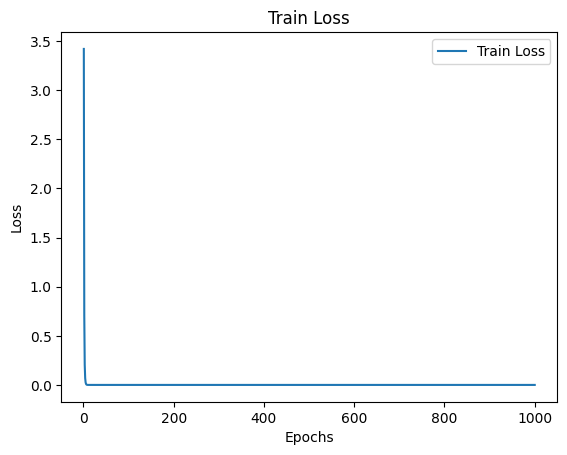

In [45]:
train_loss1 = history1.history['loss']

# Plotando o gráfico comparativo
epochs = range(1, len(train_loss1) + 1)
plt.plot(epochs, train_loss1, label='Train Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Train Loss')
plt.legend()
plt.show()

In [46]:
# Calcule o RMSE entre os dados originais e reconstruídos
rmse = (np.mean(np.square(X_train - reconstructed_data)))**0.5
print(f"RMSE: {rmse}")

RMSE: 0.0016057512826718988


### Utilizando menor dimensionalidade para segmentar os tipos de textos

Neste exemplo, vamos reduzir as 250 colunas em 16 colunas, usando a 4a camada da rede neural treinada.

In [47]:
from tensorflow.keras.models import Model

# Crie um novo modelo que inclui apenas as camadas até encoded_16
model_encoded_16 = Model(inputs=autoencoder.input, outputs=autoencoder.layers[4].output)

# Use o modelo para obter as saídas da camada encoded_16
encoded_16_outputs = model_encoded_16.predict(X_train)


type(encoded_16_outputs)

  1/567 [..............................] - ETA: 13s

567/567 [==============================] - 0s 357us/step


numpy.ndarray

### K-means & AutoEncoder

In [48]:
from sklearn.cluster import KMeans

In [49]:
# Crie um modelo K-Means com 4 clusters
# Os clusters são as segmentacoes: 'Humor', 'Leadership', 'Travel', 'Parenting'
kmeans_model = KMeans(n_clusters=4, random_state=0)

# Treine o modelo K-Means nas saídas encoded_16_outputs
kmeans_model.fit(encoded_16_outputs)

/home/somnus/Documentos/git/impacta--projetos/8-semestre/data-science/ac04/.venv/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning:

The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning

/home/somnus/Documentos/git/impacta--projetos/8-semestre/data-science/ac04/.venv/lib/python3.11/site-packages/sklearn/base.py:1152: ConvergenceWarning:

Number of distinct clusters (1) found smaller than n_clusters (4). Possibly due to duplicate points in X.



KMeans(n_clusters=4, random_state=0)

In [50]:
# Obtenha os rótulos dos clusters para cada amostra
cluster_labels = kmeans_model.labels_

len(cluster_labels)

18132

Politics, Education, Culture, Music e History

In [51]:
df_modelagem_exemplo['Clusters'] = cluster_labels

cols_mdl = []
for tag in ['Politics', 'Education', 'Culture', 'Music', 'History']:
  aux = []
  for i in range(0,len(df_modelagem_exemplo)):
    if tag in df_modelagem_exemplo['tags'][i]:
      aux.append(1)
    else:
      aux.append(0)
  colname = tag+'_Dummy'
  cols_mdl.append(colname)
  df_modelagem_exemplo[colname] = aux

/tmp/ipykernel_1122937/227903857.py:1: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

/tmp/ipykernel_1122937/227903857.py:13: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

/tmp/ipykernel_1122937/227903857.py:13: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

/tmp/ipykernel_1122937/227903857.py:13: Perf

In [52]:
df_modelagem_exemplo.groupby(['Clusters'])[cols_mdl].agg(['sum'])

,Politics_Dummy,Education_Dummy,Culture_Dummy,Music_Dummy,History_Dummy
,sum,sum,sum,sum,sum
Clusters,,,,,
0,5489,3885,4708,2835,2888


Neste exemplo, o método k-means não separou os textos, conforme os tipos.

## Testando PCA

In [53]:
from sklearn.decomposition import PCA

In [54]:
# Crie uma instância do PCA
pca = PCA(n_components=16)  # Número de componentes desejados após a redução

# Ajuste o PCA aos dados de treinamento
pca.fit(X_train)

# Transforme os dados de treinamento para as novas dimensões
X_train_pca = pca.transform(X_train)

In [55]:
X_train_pca

array([[-4.74650615e-04, -4.60998862e-04, -2.15445796e-04, ...,
         4.10386165e-03,  1.06357750e-03, -4.28993229e-04],
       [-4.88698835e-04, -4.73954472e-04, -2.50434967e-04, ...,
        -6.43041345e-05,  7.80344059e-05, -5.95644711e-04],
       [-4.41118240e-04, -4.96263497e-04, -2.55534271e-04, ...,
         1.48088843e-03, -1.36591989e-03,  3.29144920e-04],
       ...,
       [-4.62718055e-04,  2.00510505e-03, -2.07079213e-04, ...,
        -1.39189884e-04, -1.79765839e-04, -1.81598443e-04],
       [-4.62681667e-04,  2.00087727e-03, -2.07015134e-04, ...,
        -1.38708558e-04, -1.79261631e-04, -1.81631986e-04],
       [-5.15298531e-04, -5.10831308e-04, -2.43136132e-04, ...,
        -6.47419328e-03, -6.74711290e-03,  5.69065398e-04]])

### K-means & PCA

In [56]:
# Crie um modelo K-Means com 4 clusters
# Os clusters são as segmentacoes: 'Humor', 'Leadership', 'Travel', 'Parenting'
kmeans_model_pca = KMeans(n_clusters=4, random_state=0)

# Treine o modelo K-Means nas saídas encoded_16_outputs
kmeans_model_pca.fit(X_train_pca)

# Obtenha os rótulos dos clusters para cada amostra
cluster_labels2 = kmeans_model_pca.labels_

len(cluster_labels2)

/home/somnus/Documentos/git/impacta--projetos/8-semestre/data-science/ac04/.venv/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning:

The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning



18132

In [57]:
df_modelagem_exemplo['Clusters_PCA'] = cluster_labels2

df_modelagem_exemplo.groupby(['Clusters_PCA'])[cols_mdl].agg(['sum'])

/tmp/ipykernel_1122937/1796774688.py:1: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`



,Politics_Dummy,Education_Dummy,Culture_Dummy,Music_Dummy,History_Dummy
,sum,sum,sum,sum,sum
Clusters_PCA,,,,,
0,5472,3885,4695,2811,2887
1,1,0,0,24,0
2,16,0,0,0,1
3,0,0,13,0,0


### Random Forest e AutoEncoder

In [58]:
from sklearn.ensemble import RandomForestClassifier

Politics, Education, Culture, Music e History

In [59]:
classes = []
for i in range(0,len(df_modelagem_exemplo)):
  if df_modelagem_exemplo['Politics_Dummy'][i] == 1:
    classes.append(1)
  elif df_modelagem_exemplo['Education_Dummy'][i] == 1:
    classes.append(2)
  elif df_modelagem_exemplo['Culture_Dummy'][i] == 1:
    classes.append(3)
  elif df_modelagem_exemplo['Music_Dummy'][i] == 1:
    classes.append(4)

  elif df_modelagem_exemplo['History_Dummy'][i] == 1:
    classes.append(5)
  else:
    print("ver indice: ",i)


In [60]:
# Divida os dados em conjuntos de treinamento e teste
X_train2, X_test, y_train, y_test = train_test_split(X_train, classes, test_size=0.2, random_state=42)

# Crie um modelo de Random Forest
random_forest_model = RandomForestClassifier(n_estimators=100, random_state=42,min_samples_leaf=50)

# Treine o modelo
random_forest_model.fit(X_train2, y_train)

# Faça previsões no conjunto de teste
predictions = random_forest_model.predict(X_test)

# Calcule a acurácia das previsões
accuracy = accuracy_score(y_test, predictions)
print(f"Acurácia: {accuracy}")

Acurácia: 0.5059277639922801


In [61]:
X_train3 = X_test.copy()
X_train3['y'] = y_test
X_train3['predictions'] = predictions

In [62]:
table = X_train3.groupby(['predictions', 'y']).size().unstack(fill_value=0)
table

y,1,2,3,4,5
predictions,,,,,
1,818,140,247,46,216
2,126,385,143,86,56
3,112,190,381,118,133
4,23,33,83,228,17
5,3,6,14,0,23


In [63]:
table2 = table/table.sum()
table2

y,1,2,3,4,5
predictions,,,,,
1,0.756007,0.185676,0.284562,0.096234,0.485393
2,0.116451,0.510610,0.164747,0.179916,0.125843
3,0.103512,0.251989,0.438940,0.246862,0.298876
4,0.021257,0.043767,0.095622,0.476987,0.038202
5,0.002773,0.007958,0.016129,0.000000,0.051685


### Conclusao

Percebemos que com algoritmo supervisionado, os temas 1, 2 e 3 foram previstos com maior facilidade, usando apenas 16 variáveis explicativas.

Já o algoritmo não supervisionado não foi capaz de realizar a separação como o esperado.

Vale ressaltar, que a maior frequência de preditos foi do respectivo tema corretamente. Em outras palavras, para o tema 4 cuja assertividade foi menor, 35% dos casos foram previstos para o tema 4.

# Exercicios

1. Realize um teste usando as camadas encoded_128, encoded_64 e encoded_32 da rede neural já treinada. Avalie se o método K-means e Random Forest seriam capazes de acertar mais as predições, usando os mesmos parâmetros dos exemplos.

Em outras palavras,
3 outputs de rede neural * 2 algoritmos = **6 modelos diferentes**.

2. Baseado na prática que teve maior assertividade na etapa anterior, treine uma rede neural com a mesma arquitetura para os demais temas.

Sugestão: utilize o código abaixo:



```
df_modelagem_atividade = df.loc[((df['Humor'] != 1) & (df['Leadership'] != 1) & (df['Travel'] != 1) & (df['Parenting'] != 1)), ['title', 'text', 'url', 'authors', 'timestamp', 'tags']]
```
**Lembrete:** é preciso realizar toda a etapa de tratamento e transformação nos dados. Talvez seja mais simples criar uma cópia deste notebook e alterar apenas a base de modelagem.




In [64]:
df_modelagem_atividade = df.loc[((df['Humor'] != 1) & (df['Leadership'] != 1) & (df['Travel'] != 1) & (df['Parenting'] != 1)), ['title', 'text', 'url', 'authors', 'timestamp', 'tags']].reset_index(drop=True)

In [65]:
df_modelagem_atividade.tail()

,title,text,url,authors,timestamp,tags
182629,Why do you need a cleaning service?,What could be more important than having a tid...,https://medium.com/@ozneedcleaningau/why-do-yo...,[],2021-11-16 08:17:08.950000+00:00,"['Cleaning', 'Cleaning Services', 'Cleaning Co..."
182630,Daily cleaning and maintenance of bedding,Daily cleaning and maintenance of bedding\n\nW...,https://medium.com/@a198blwt/daily-cleaning-an...,[],2021-11-16 05:27:05.359000+00:00,"['Bedding', 'Cleaning', 'Maintain']"
182631,Beneficial Advice on Bond Cleaning!,The most important chore at the end is bond cl...,https://medium.com/@princegohil/beneficial-adv...,['Prince Shrawan'],2021-11-26 08:20:27.660000+00:00,"['Cleaning', 'End Of Lease Cleaning', 'Cleaners']"
182632,How I Learned Romanian in 37 Easy Steps,How I Learned Romanian in 37 Easy Steps\n\nHey...,https://medium.com/@lifeinromania/how-i-learne...,['Sam Ursu'],2017-11-27 08:09:19.025000+00:00,"['Romania', 'Language Learning', 'Storyofmylife']"
182633,Trying Pimsleur Cantonese in Hong Kong,"Over the past few years, I’ve heard a number o...",https://medium.com/toshuo/trying-pimsleur-cant...,[],2017-06-15 02:24:35.659000+00:00,"['Hong Kong', 'Cantonese', 'Language Learning'..."


## EX 1


In [66]:
from tensorflow.keras.models import Model

# Crie um novo modelo que inclui apenas as camadas até encoded_16
model_encoded_32 = Model(inputs=autoencoder.input, outputs=autoencoder.layers[3].output)

model_encoded_64 = Model(inputs=autoencoder.input, outputs=autoencoder.layers[2].output)

model_encoded_128 = Model(inputs=autoencoder.input, outputs=autoencoder.layers[1].output)

# Use o modelo para obter as saídas da camada encoded_16
encoded_32_outputs = model_encoded_32.predict(X_train)

encoded_64_outputs = model_encoded_64.predict(X_train)

encoded_128_outputs = model_encoded_128.predict(X_train)

154/567 [=======>......................] - ETA: 0s 

567/567 [==============================] - 0s 324us/step


In [67]:
## print all encoded collumns count
print(encoded_32_outputs.shape)
print(encoded_64_outputs.shape)
print(encoded_128_outputs.shape)

(18132, 32)
(18132, 64)
(18132, 128)


In [68]:
from sklearn.cluster import KMeans
# Crie um modelo K-Means com 4 clusters
# Os clusters são as segmentacoes: 'Humor', 'Leadership', 'Travel', 'Parenting'
kmeans_model_32 = KMeans(n_clusters=4, random_state=0)

kmeans_model_64 = KMeans(n_clusters=4, random_state=0)

kmeans_model_128 = KMeans(n_clusters=4, random_state=0)


# Treine o modelo K-Means nas saídas encoded_16_outputs
kmeans_model_32.fit(encoded_32_outputs)

kmeans_model_64.fit(encoded_64_outputs)

kmeans_model_128.fit(encoded_128_outputs)

/home/somnus/Documentos/git/impacta--projetos/8-semestre/data-science/ac04/.venv/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning:

The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning

/home/somnus/Documentos/git/impacta--projetos/8-semestre/data-science/ac04/.venv/lib/python3.11/site-packages/sklearn/base.py:1152: ConvergenceWarning:

Number of distinct clusters (1) found smaller than n_clusters (4). Possibly due to duplicate points in X.

/home/somnus/Documentos/git/impacta--projetos/8-semestre/data-science/ac04/.venv/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning:

The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning

/home/somnus/Documentos/git/impacta--projetos/8-semestre/data-science/ac04/.venv/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning:

The

KMeans(n_clusters=4, random_state=0)

In [69]:
# Obtenha os rótulos dos clusters para cada amostra
cluster_labels = kmeans_model_32.labels_

len(cluster_labels)

18132

# Teste Encoder 32

## K-Means

In [70]:
cluster_labels_32 = kmeans_model_32.labels_


df_modelagem_exemplo['Clusters'] = cluster_labels_32

cols_mdl = []
for tag in ['Politics', 'Education', 'Culture', 'Music', 'History']:
  aux = []
  for i in range(0,len(df_modelagem_exemplo)):
    if tag in df_modelagem_exemplo['tags'][i]:
      aux.append(1)
    else:
      aux.append(0)
  colname = tag+'_Dummy'
  cols_mdl.append(colname)
  df_modelagem_exemplo[colname] = aux

In [71]:
df_modelagem_exemplo.groupby(['Clusters'])[cols_mdl].agg(['sum'])

,Politics_Dummy,Education_Dummy,Culture_Dummy,Music_Dummy,History_Dummy
,sum,sum,sum,sum,sum
Clusters,,,,,
0,5489,3885,4708,2835,2888


## Random Forest

In [72]:
classes = []
for i in range(0,len(df_modelagem_exemplo)):
  if df_modelagem_exemplo['Politics_Dummy'][i] == 1:
    classes.append(1)
  elif df_modelagem_exemplo['Education_Dummy'][i] == 1:
    classes.append(2)
  elif df_modelagem_exemplo['Culture_Dummy'][i] == 1:
    classes.append(3)
  elif df_modelagem_exemplo['Music_Dummy'][i] == 1:
    classes.append(4)

  elif df_modelagem_exemplo['History_Dummy'][i] == 1:
    classes.append(5)
  else:
    print("ver indice: ",i)

In [73]:
# Divida os dados em conjuntos de treinamento e teste
X_train2, X_test, y_train, y_test = train_test_split(encoded_32_outputs, classes, test_size=0.2, random_state=42)

# Crie um modelo de Random Forest
random_forest_model = RandomForestClassifier(n_estimators=100, random_state=42,min_samples_leaf=50)

# Treine o modelo
random_forest_model.fit(X_train2, y_train)

# Faça previsões no conjunto de teste
predictions = random_forest_model.predict(X_test)

# Calcule a acurácia das previsões
accuracy = accuracy_score(y_test, predictions)
print(f"Acurácia: {accuracy}")

Acurácia: 0.2983181692859112


In [74]:
# X_train3 = X_test.copy()
# X_train3['y'] = y_test
# X_train3['predictions'] = predictions

In [75]:
X_train3 = pd.DataFrame(X_test)
X_train3['y'] = y_test
X_train3['predictions'] = predictions


In [76]:
table = X_train3.groupby(['predictions', 'y']).size().unstack(fill_value=0)
table

y,1,2,3,4,5
predictions,,,,,
1,1082,754,868,478,445


In [77]:
table2 = table/table.sum()
table2

y,1,2,3,4,5
predictions,,,,,
1,1.0,1.0,1.0,1.0,1.0


# Teste Encoder 64

## K-Means

In [78]:
cluster_labels_64 = kmeans_model_64.labels_


df_modelagem_exemplo['Clusters'] = cluster_labels_64

cols_mdl = []
for tag in ['Politics', 'Education', 'Culture', 'Music', 'History']:
  aux = []
  for i in range(0,len(df_modelagem_exemplo)):
    if tag in df_modelagem_exemplo['tags'][i]:
      aux.append(1)
    else:
      aux.append(0)
  colname = tag+'_Dummy'
  cols_mdl.append(colname)
  df_modelagem_exemplo[colname] = aux



In [79]:
df_modelagem_exemplo.groupby(['Clusters'])[cols_mdl].agg(['sum'])

,Politics_Dummy,Education_Dummy,Culture_Dummy,Music_Dummy,History_Dummy
,sum,sum,sum,sum,sum
Clusters,,,,,
0,5401,3812,4603,2775,2815
1,80,67,92,48,65
2,7,4,10,12,7
3,1,2,3,0,1


## Random Forest

In [80]:
classes = []
for i in range(0,len(df_modelagem_exemplo)):
  if df_modelagem_exemplo['Politics_Dummy'][i] == 1:
    classes.append(1)
  elif df_modelagem_exemplo['Education_Dummy'][i] == 1:
    classes.append(2)
  elif df_modelagem_exemplo['Culture_Dummy'][i] == 1:
    classes.append(3)
  elif df_modelagem_exemplo['Music_Dummy'][i] == 1:
    classes.append(4)
  elif df_modelagem_exemplo['History_Dummy'][i] == 1:
    classes.append(5)
  else:
    print("ver indice: ",i)

In [81]:
# Divida os dados em conjuntos de treinamento e teste
X_train2, X_test, y_train, y_test = train_test_split(encoded_64_outputs, classes, test_size=0.2, random_state=42)

# Crie um modelo de Random Forest
random_forest_model = RandomForestClassifier(n_estimators=100, random_state=42,min_samples_leaf=50)

# Treine o modelo
random_forest_model.fit(X_train2, y_train)

# Faça previsões no conjunto de teste
predictions = random_forest_model.predict(X_test)

# Calcule a acurácia das previsões
accuracy = accuracy_score(y_test, predictions)
print(f"Acurácia: {accuracy}")

Acurácia: 0.2983181692859112


In [82]:
# X_train3 = X_test.copy()
# X_train3['y'] = y_test
# X_train3['predictions'] = predictions

In [83]:
X_train3 = pd.DataFrame(X_test)
X_train3['y'] = y_test
X_train3['predictions'] = predictions


In [84]:
table = X_train3.groupby(['predictions', 'y']).size().unstack(fill_value=0)
table

y,1,2,3,4,5
predictions,,,,,
1,1082,754,868,478,445


In [85]:
table2 = table/table.sum()
table2

y,1,2,3,4,5
predictions,,,,,
1,1.0,1.0,1.0,1.0,1.0


# Teste Encoder 128

## K-Means

In [86]:
cluster_labels_128 = kmeans_model_128.labels_


df_modelagem_exemplo['Clusters'] = cluster_labels_128

cols_mdl = []
for tag in ['Politics', 'Education', 'Culture', 'Music', 'History']:
  aux = []
  for i in range(0,len(df_modelagem_exemplo)):
    if tag in df_modelagem_exemplo['tags'][i]:
      aux.append(1)
    else:
      aux.append(0)
  colname = tag+'_Dummy'
  cols_mdl.append(colname)
  df_modelagem_exemplo[colname] = aux

In [87]:
df_modelagem_exemplo.groupby(['Clusters'])[cols_mdl].agg(['sum'])

,Politics_Dummy,Education_Dummy,Culture_Dummy,Music_Dummy,History_Dummy
,sum,sum,sum,sum,sum
Clusters,,,,,
0,82,38,65,31,26
1,5187,3795,4549,2742,2764
2,100,16,13,17,27
3,120,36,81,45,71


## Random Forest

In [88]:
from sklearn.ensemble import RandomForestClassifier

In [89]:
classes = []
for i in range(0,len(df_modelagem_exemplo)):
  if df_modelagem_exemplo['Politics_Dummy'][i] == 1:
    classes.append(1)
  elif df_modelagem_exemplo['Education_Dummy'][i] == 1:
    classes.append(2)
  elif df_modelagem_exemplo['Culture_Dummy'][i] == 1:
    classes.append(3)
  elif df_modelagem_exemplo['Music_Dummy'][i] == 1:
    classes.append(4)
  elif df_modelagem_exemplo['History_Dummy'][i] == 1:
    classes.append(5)
  else:
    print("ver indice: ",i)


In [90]:
# Divida os dados em conjuntos de treinamento e teste
X_train2, X_test, y_train, y_test = train_test_split(encoded_128_outputs, classes, test_size=0.2, random_state=42)

# Crie um modelo de Random Forest
random_forest_model = RandomForestClassifier(n_estimators=100, random_state=42,min_samples_leaf=50)

# Treine o modelo
random_forest_model.fit(X_train2, y_train)

# Faça previsões no conjunto de teste
predictions = random_forest_model.predict(X_test)

# Calcule a acurácia das previsões
accuracy = accuracy_score(y_test, predictions)
print(f"Acurácia: {accuracy}")

Acurácia: 0.2983181692859112


In [91]:
# X_train3 = X_test.copy()
# X_train3['y'] = y_test
# X_train3['predictions'] = predictions

In [92]:
X_train3 = pd.DataFrame(X_test)
X_train3['y'] = y_test
X_train3['predictions'] = predictions

In [93]:
table = X_train3.groupby(['predictions', 'y']).size().unstack(fill_value=0)
table

y,1,2,3,4,5
predictions,,,,,
1,1082,754,868,478,445


In [94]:
table2 = table/table.sum()
table2

y,1,2,3,4,5
predictions,,,,,
1,1.0,1.0,1.0,1.0,1.0
